In [1]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
matplotlib.style.use('seaborn')
sns.set(style='whitegrid', color_codes=True)

save_path = './figures'
if not os.path.exists(save_path):
    os.makedirs(save_path) 

save_type = '.png' 

In [3]:
def remove_pts(x,y, kill_num=800):
    randidx = []
    hf = kill_num // 2

    idx = np.where(y==0)[0]
    sorted_idx = x[:,0][idx].argsort()
    randidx.append( idx[sorted_idx[len(sorted_idx)-hf:]] )

    idx = np.where(y==2)[0]
    sorted_idx = x[:,1][idx].argsort()
    randidx.append( idx[sorted_idx[:(kill_num-hf)]] )

    randidx = np.concatenate(randidx)

    x = np.delete(x, randidx, axis=0)
    y = np.delete(y, randidx, axis=0)
    
    return x, y

In [4]:
def draw_scatter(x, y, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(8,7)).add_subplot(111)

    axes = plt.gca()
    axes.set_xlim([-6,6])
    axes.set_ylim([-4.5,6.5])
    fig.tick_params(labelsize=20)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.08, top=0.92)

    kk = y.max() + 1
    color = [
        sns.xkcd_rgb['soft pink'],
        sns.xkcd_rgb['windows blue'],
        sns.xkcd_rgb['macaroni and cheese'],
        sns.xkcd_rgb['soft green'],
    ]

    for k in range(kk):
        idx = np.where(y==k)
        pts = x[idx]
        plt.scatter(pts[:,0], y=pts[:,1], alpha=0.3, edgecolors='none', color=color[k])

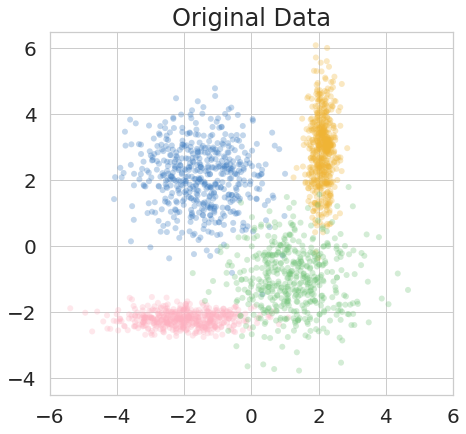

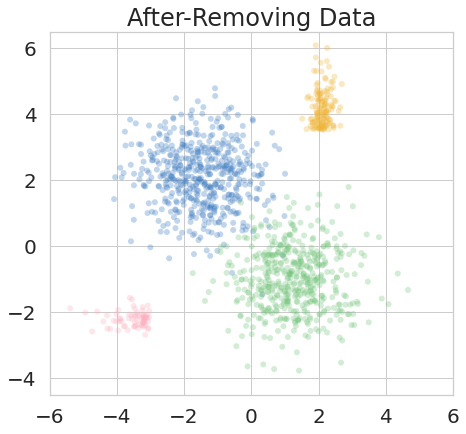

In [5]:
with open('../data/GMMs/gmm-2d-syn-set.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)

fig = plt.figure(figsize=(7,6)).add_subplot(111)

plt.title('Original Data', fontsize=24)

draw_scatter(raw_dataset['x'], raw_dataset['y'], fig)
plt.savefig(save_path+'/gmm-raw-data'+save_type)


remain_x, remain_y = remove_pts(raw_dataset['x'], raw_dataset['y'], kill_num=800)

fig = plt.figure(figsize=(7,6)).add_subplot(111)
plt.title('After-Removing Data', fontsize=24)

draw_scatter(remain_x, remain_y, fig)
plt.savefig(save_path+'/gmm-rm-data'+save_type)

In [6]:
class Fun2d():
    def __init__(self, mu, std):
        self.mu = mu
        self.std = std
        self.pre_cof = 1 / (2 * np.pi * std[0] * std[1])
        
    def __call__(self, x, y):
        res = ((x - self.mu[0])**2) / ( 2*(self.std[0]**2) )
        res += ((y - self.mu[1])**2) / ( 2*(self.std[1]**2) )
        res = np.exp(-res) * self.pre_cof
        print(res.shape)
        return res

In [7]:
def draw_contour(kk, mu, std, fig=None):
    delta = 0.02
    x = np.arange(-4.0, 4.0, delta)
    y = np.arange(-4.0, 5.0, delta)
    X, Y = np.meshgrid(x, y)
    if fig is None:
        fig = plt.figure(figsize=(8,7)).add_subplot(111)
    print('kk = {}'.format(kk))
    for k in range(kk):
        fun = Fun2d(mu[:,k].reshape(-1), std[:,k].reshape(-1))
        print(mu[:,k].reshape(-1))
        print(std[:,k].reshape(-1))
        print('')
        Z = fun(X, Y)
        CS = fig.contour(X, Y, Z,levels=10)
        fig.clabel(CS, inline=1, fontsize=10)
        fig.scatter(mu[0,k], mu[1,k], color='black')

In [8]:
def plot_clusters(kk, mu, fig=None, color='black', marker='o', label=None):
    if fig is None:
        fig = plt.figure(figsize=(8,7)).add_subplot(111)
    fig.scatter(mu[0,:], mu[1,:], color=color, marker=marker, zorder=3, linewidths=3, label=label)

dict_keys(['kk', 'dim', 'std', 'mk', 'sk'])


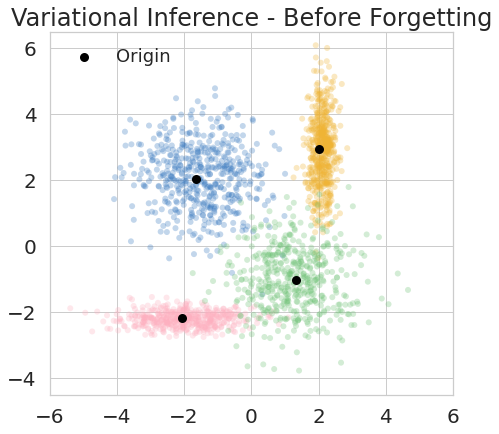

In [9]:
# variational inference
with open('../exp_data/gmm/svi/full-train-ckpt-cluster.pkl', 'rb') as f:
    svi_res = pickle.load(f)
print(svi_res.keys())
fig = plt.figure(figsize=(7,6)).add_subplot(111)
plt.title('Variational Inference - Before Forgetting', fontsize=24)

draw_scatter(raw_dataset['x'], raw_dataset['y'], fig)
plot_clusters(svi_res['kk'], svi_res['mk'], fig, color=sns.xkcd_rgb['black'], marker='o', label='Origin')
plt.legend(loc='upper left', fontsize=18)
plt.savefig(save_path+'/gmm-SVI-full'+save_type)

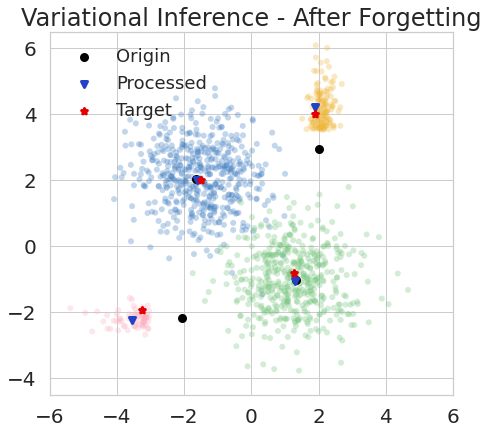

In [10]:
# variational inference
with open('../exp_data/gmm/svi/forget-ckpt-cluster.pkl', 'rb') as f:
    svi_fo_res = pickle.load(f)

fig = plt.figure(figsize=(7,6)).add_subplot(111)
plt.title('Variational Inference - After Forgetting', fontsize=24)

draw_scatter(remain_x, remain_y, fig)
plot_clusters(svi_res['kk'], svi_res['mk'], fig, color=sns.xkcd_rgb['black'], marker='o', label='Origin')
plot_clusters(svi_fo_res['kk'], svi_fo_res['mk'], fig, color=sns.xkcd_rgb['blue blue'], marker='v', label='Processed')

with open('../exp_data/gmm/svi/scratch-ckpt-cluster.pkl', 'rb') as f:
    svi_sc_res = pickle.load(f)
plot_clusters(svi_sc_res['kk'], svi_sc_res['mk'], fig, color=sns.xkcd_rgb['red'], marker='*', label='Target')
plt.legend(loc='upper left', fontsize=18)

plt.savefig(save_path+'/gmm-SVI-forget'+save_type)